# Grokking **FizzBuzz** using `MXNet`

Last year, Joel Grus wrote a brilliant [article](http://joelgrus.com/2016/05/23/fizz-buzz-in-tensorflow/) on *fizzbuzz*. He had attended an interview and was asked about *fizzbuzz*. He went on to solve it using `tensorflow`. Now, you may wonder why should we use deep learning for this? Atleast, I thought that way and didn't really pay much attention to the code. 

This summer, I had an opportunity to interview with an AI-startup that I really liked. And guess what? I was asked to solve `fizzbuzz` using deep learning. Long story short, neither Joel nor I got the job ! 

But this made me think about why `fizzbuzz` makes sense? But before we get on to that, what is this `fizzbuzz` problem?

**What is fizzbuzz ?**

Given an integer `x`, the output is determined by the following rules:

- if `x` is divisible by 3, output is "fizz"
- if `x` is divisible by 5, output is "buzz"
- if `x` is divisible by 15, output is "fizzbuzz"
- else, the output is `x`

A typical output sequence will look like this

| Input   |      Output      | 
|----------|:-------------:|
| 1 |  1 |
| 2 |  2 |
| 3 | "fizz" |
| 4 | 4 |
| 5 | "buzz" |
| 6 | "fizz" |
| 7 | 7 |
| 8 | 8 |
| 9 | "fizz" |
| 10 | "buzz" |
| 11 | 11 |
| 12 | "fizz" |
| 13 | 13 |
| 14 | 14 |
| 15 | "fizzbuzz" |
| 16 | 16 |

If we know the rules that generate the data, there's really no need for machine learning. Unfortunately, in real-life, we only have the data. The goal of machine learning is to learn the function that generated the data. In this aspect, `fizzbuzz` provides us with an easy-to-understand dataset and allows us to understand and explore the algorithms better. 

What follows below is a pedantic exercise in understanding how `MXNet` can be used to solve the `fizzbuzz` problem. 

**What is `MXNet`?**

`MXNet` is a scalable open-source deep learning framework. It scales to multiple GPUs and multiple machines. At Amazon, `MXNet` is the deep learning framework of choice at AWS. It is supported by Intel, Dato, Baidu, Microsoft, MIT amongst others. 


**Structure of the article**

In the subsequent sections, we will do the following

1. Structure the problem as a multi-class classification problem
2. Generate the fizzbuzz data
3. Divide the data into train and test
4. Build a logistic regression model in `MXNet` from scratch
5. Introduce `Gluon`
6. Build a multi-layer-perceptron model using `Gluon`
7. Build a Convolutional Neural Network model

**Structure the problem**

Given the data, how do we structure this as a machine learning problem? To do supervised machine learning, we need features and a target variable. *Fizzbuzz* can be modeled as a multi-class classification problem. 

Let's first start with the target. The target can be one of the four classes - "fizz", "buzz", "fizzbuzz" or "the given number". The model should predict which of the classes is most likely for the given input number. The 4 classes are encoded and the model will be built. Once the model is built, using the prediction label, we will need a decoder function. The decoder function will convert the label to the corresponding output. 

Now, let's think of a way to do feature engineering for the input. The input is an integer. One option we could explore is convert the number to its binary representation. The binary representation could be of fixed-length. And each digit of the fixed-length binary representation can be an input feature.

An example will explain this better.

Let's say, we train the model using the first 1000 integers. To create a binary representation of fixed length, we first need to find the maximum length of the input vector. 2^10 is 1024. So, we need the input vector to be of length 10.

The output is encoded as 0, 1, 2, 3 for "fizzbuzz", "buzz", "fizz" and "the given number" respectively.

**Examples**

*Example 1*

Input: 100  
Output: "buzz"  

The input feature: 0001100100  
Output label: 1  

*Example 2*

Input: 11  
Output: "the given number"  

The input feature: 0000001011   
Output label: 3  

Now, let's start building models using `mxnet`. Each digit of the input feature vector will be an input neuron. The output will have 4 neurons, one corresponding to each of the classes. 



**Generate the data**

Let's now generate the data. Let's first import the required libraries `numpy` and `mxnet`.

One way to install `mxnet` is to run the following command

In [ ]:
#install mxnet. If its already available, upgrade it.
!pip install mxnet --upgrade --pre

In [ ]:
#import libraries
import numpy as np
import mxnet as mx
import os
mx.random.seed(1)  

In `mxnet`, every array has a context - either on a GPU or CPU. 

The data size won't be too high for this exercise and CPU should suffice. 

In [ ]:
#Define the context to be CPU
ctx = mx.cpu()

**helper functions**

We need a few helper functions to start with.

We need a function to convert the given input integer to its binary form.

In [ ]:
#function to encode the integer to its binary representation
def binary_encode(i, num_digits):
    return np.array([i >> d & 1 for d in range(num_digits)])

We need a function to encode the target into one of the 4 classes.

In [ ]:
#function to encode the target into multi-class
def fizz_buzz_encode(i):
    if   i % 15 == 0: 
        return 0
    elif i % 5  == 0: 
        return 1
    elif i % 3  == 0: 
        return 2
    else:             
        return 3

Once the model is built and we use it to predict it for a given number, we need a function that maps the prediction to the right output. The following function helps us do that.

In [ ]:
#Given prediction, map it to the correct output label
def fizz_buzz(i, prediction):
    if prediction == 0:
        return "fizzbuzz"
    elif prediction == 1:
        return "buzz"
    elif prediction == 2:
        return "fizz"
    else:
        return str(i)

**Create train, validation, test datasets**

We now need to create the train, validation and test datasets.

Let's generate 100,000 data points. That's the first 100,000 integers.

In ideal case, the train, validation and test datasets are randomly selected. But for sake of simplicity, let's use the first 100 integers as test dataset. We won't use this for training. Once we create the model, we will check the accuracy of the model by predicting on the test dataset.

We will use the integers 101 to 50,000 as training dataset. We will build the model using this dataset.

We will use integers 50,001 to 100,000 as validation dataset. We could use this for hyper-parameter tuning. In this exercise, we wouldn't be doing hyper-parameter tuning though.

We first start by defining the number of integers to generate

In [ ]:
#Number of integers to generate
MAX_NUMBER = 100000

The length of the input feature vector has to be determined. 

In [ ]:
#The input feature vector is determined by NUM_DIGITS
NUM_DIGITS = np.log2(MAX_NUMBER).astype(np.int)+1

The train, test and validation datasets are generated

In [ ]:
#Generate training dataset - both features and labels
trainX = np.array([binary_encode(i, NUM_DIGITS) for i in range(101, np.int(MAX_NUMBER/2))])
trainY = np.array([fizz_buzz_encode(i)          for i in range(101, np.int(MAX_NUMBER/2))])

In [ ]:
#Generate validation dataset - both features and labels
valX = np.array([binary_encode(i, NUM_DIGITS) for i in range(np.int(MAX_NUMBER/2), MAX_NUMBER)])
valY = np.array([fizz_buzz_encode(i)          for i in range(np.int(MAX_NUMBER/2), MAX_NUMBER)])

In [ ]:
#Generate test dataset - both features and labels
testX = np.array([binary_encode(i, NUM_DIGITS) for i in range(1, 101)])
testY = np.array([fizz_buzz_encode(i)          for i in range(1, 101)])

Now that we've created the train, test and validation datasets, let's use `mxnet's` iterator `NDArrayIter`. It allows us to specify batch size for training and also allows us to set a flag to shuffle the data or not.

In [ ]:
#Define the parameters
batch_size = 100
num_inputs = NUM_DIGITS
num_outputs = 4

In [ ]:
#Create iterator for train, test and validation datasets
train_data = mx.io.NDArrayIter(trainX, trainY,
                               batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(valX, valY,
                               batch_size, shuffle=True)
test_data = mx.io.NDArrayIter(testX, testY,
                              batch_size, shuffle=False)

We need to write another helper function. This one is to evaluate the accuracy of the model.

In [ ]:
#Function to evaluate accuracy of the model

def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return predictions,acc.get()[1]

**Logistic Regression from scratch**

Now that we have the data and the helper functions in place, let's go ahead and build logistic regression from scratch. [This](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter02_supervised-learning/softmax-regression-scratch.ipynb) article does a wonderful job of building a multi-class logistic regression from scratch using `mxnet`. We will follow a similar template for our problem

`mxnet` comes with a `autograd` package. `autograd` enables automatic differentiation of NDArray operations and is used to compute the gradients of the loss function with respect to the model weights. More about `autograd` can be found [here](https://mxnet.incubator.apache.org/api/python/autograd.html)

In [ ]:
#import autograd package
from mxnet import autograd, nd

The first step is to initialize the bias and weight matrix.

In [ ]:
#Initialize the weight and bias matrix

#weights matrix
W = nd.random_normal(shape=(num_inputs, num_outputs))
#bias matrix
b = nd.random_normal(shape=num_outputs)

#Model parameters
params = [W, b]

The next step is to allocate space for each parameter's gradients

In [ ]:
for param in params:
    param.attach_grad()

We want the output to be the probability for each of the classes. The sum of the probabilities should sum upto one. This is accomplished by the softmax 

In [ ]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear))
    norms = nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / norms

The loss function we will be using is softmax cross entropy. Cross-entropy maximizes the log-likelihood given to the correct labels. More about softmax cross-entropy can be read [here](https://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/)

In [ ]:
#loss function
def softmax_cross_entropy(yhat, y):
    return - nd.nansum(y * nd.log(yhat), axis=0, exclude=True)

We now define the model

In [ ]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

For the model to learn(update) the model parameters(weights and biases), we need to define an optimizer. Stochastic Gradient Descent is one of the most popular methods to update the parameters.

In [ ]:
#Define the optimizer
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

Lets execute the training loops. For each training step, batch_size determines the number of data points that will be passed through the network to learn. Once all data points are passed through the network, one epoch is completed. The parameter `epochs` define the number of times the entire dataset has to be cycled through the training process. 

In [ ]:
#hyper paramters for the training
epochs = 100
learning_rate = .01
smoothing_constant = .01

Let's now execute the training function

In [13]:
for e in range(epochs):
    #at the start of each epoch, the train data iterator is reset
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 4)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

    #the training and validation accuracies are computed
    _,val_accuracy = evaluate_accuracy(val_data, net)
    _,train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Val_acc %s" %
          (e, moving_loss, train_accuracy, val_accuracy))

Epoch 99. Loss: 1.18811465231, Train_acc 0.532825651303, Val_acc 0.5332


For 100 epochs, the train accuracy and validation accuracy doesn't seem to be great. It is only around 53%. Let's see what's the accuracy on the test dataset

In [14]:
#model accuracy on the test dataset
predictions,test_accuracy = evaluate_accuracy(test_data, net)
output = np.vectorize(fizz_buzz)(np.arange(1, 101), predictions.asnumpy().astype(np.int))
print(output)
print("Test Accuracy : ",test_accuracy)

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44' '45' '46'
 '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61'
 '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76'
 '77' '78' '79' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91'
 '92' '93' '94' '95' '96' '97' '98' '99' '100']
Test Accuracy :  0.53


The accuracy on the test dataset is also 53%. The model doesn't seem to be working well. 

Let's now look into doing the same using `Gluon`

**What is `Gluon`?**

Gluon package is a high-level interface for MXNet. Gluon supports both imperative and symbolic programming, making it easy to train complex models imperatively. More details can be found [here](https://mxnet.incubator.apache.org/api/python/gluon.html)

**Multi-layer perceptron using `Gluon`**

Let's build a multi-layer perceptron(MLP) model using `gluon`. 

MLP is one of the simplest deep learning models. More details can be found on [wikipedia](https://en.wikipedia.org/wiki/Multilayer_perceptron)
![](img/MLP.jpg)

[image source](http://file.scirp.org/Html/2-2200704_39386.htm)

We first need to import `gluon`

In [ ]:
#import gluon
from mxnet import gluon

In [15]:
#reset the training, test and validation iterators
train_data.reset()
val_data.reset()
test_data.reset()

Now, define the Gluon Sequential Model. Each hidden layer is added sequentially. the `num_hidden` variable defines the number of neurons in each of the hidden layers. The `relu` activation function is used in each of the layers

In [16]:
#Define number of neurons in each hidden layer
num_hidden = 64
#Define the sequential network
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(num_inputs, activation="relu"))
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

Similar to the previous exercise, where we built the model from scratch, the parameters need to be initialized. 

In [17]:
#initialize parameters
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

The loss function is defined to be softmax cross entropy.

In [18]:
#define the loss function
loss = gluon.loss.SoftmaxCrossEntropyLoss()

The optimizer is chosen to be stochastic gradient descent, similar to the previous model. For this model, we define both the learning rate and momentum. 

In [19]:
#Define the optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .02,'momentum':0.9})

Let's now train the MLP model

In [ ]:
#define variables/hyper-paramters
epochs = 100
moving_loss = 0.
best_accuracy = 0.
best_epoch = -1

In [20]:
#train the model
for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data.shape[0])
        if i == 0:
            moving_loss = nd.mean(cross_entropy).asscalar()
        else:
            moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()

    _,val_accuracy = evaluate_accuracy(val_data, net)
    _,train_accuracy = evaluate_accuracy(train_data, net)
    
    if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            if best_epoch!=-1:
                print('deleting previous checkpoint...')
                os.remove('mlp-%d.params'%(best_epoch))
            best_epoch = e
            print('Best validation accuracy found. Checkpointing...')
            net.save_params('mlp-%d.params'%(e))
    print("Epoch %s. Loss: %s, Train_acc %s, Val_acc %s" %
          (e, moving_loss, train_accuracy, val_accuracy))

Best validation accuracy found. Checkpointing...
Epoch 99. Loss: 0.021456909065, Train_acc 0.99498997996, Val_acc 0.44902


The training accuracy looks good - but validation accuracy is terrible. This generally is a sign of overfitting.

Let's now predict it on the test dataset

In [21]:
#Load the parameters
net.load_params('mlp-%d.params'%(best_epoch), ctx)

In [22]:
#predict on the test dataset
predictions,test_accuracy = evaluate_accuracy(test_data, net)
output = np.vectorize(fizz_buzz)(np.arange(1, 101), predictions.asnumpy().astype(np.int))
print(output)
print("Test Accuracy : ",test_accuracy)

['1' '2' '3' '4' 'buzz' '6' '7' '8' 'fizz' 'buzz' '11' 'fizz' '13' '14'
 '15' 'buzz' '17' 'fizz' '19' 'buzz' 'fizz' '22' '23' 'fizz' 'buzz' '26'
 'fizz' '28' '29' 'fizzbuzz' '31' 'buzz' 'fizz' '34' 'buzz' 'fizz' '37'
 '38' '39' 'buzz' '41' 'fizz' '43' 'buzz' '45' 'buzz' '47' 'fizz' '49'
 'buzz' 'fizz' '52' '53' 'fizz' 'buzz' '56' 'fizz' '58' '59' 'fizz' 'buzz'
 '62' 'fizz' '64' 'buzz' '66' '67' '68' '69' 'buzz' '71' 'fizz' '73' '74'
 '75' '76' '77' '78' '79' 'buzz' 'fizz' '82' '83' 'fizz' 'buzz' '86' '87'
 '88' '89' 'fizzbuzz' '91' '92' 'fizz' '94' 'buzz' 'fizz' '97' '98' '99'
 'buzz']
Test Accuracy :  0.83


The test accuracy is 83%. Let's try to explore another model architecture to see how the model accuracy is

**Convolutional Neural Network**



CNN is a deep learning architecture that's widely used in image recognition. 

The two key layers in a CNN architecture are the convolution layer and the pooling layer.

The convolution layer applies a convolution operation to the input. Convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel. More information can be found at [wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing)

The pooling layer combine the outputs of neuron clusters at one layer into a single neuron in the next layer. For example, if the method is to use max pooling and the neuron cluster is 2x2 - every 2x2 pixels is replaced by the maximum value amongst those 4 pixels.




The first step is to reshape the data for CNN:  
(x_dim,y_dim) &rarr; (x_dim,#of channels = 1,y_dim) 

In [23]:
#reshape train, test and validation datasets
trainX= trainX.reshape(trainX.shape[0],1,trainX.shape[1])
valX= valX.reshape(valX.shape[0],1,valX.shape[1])
testX= testX.reshape(testX.shape[0],1,testX.shape[1])

Define the iterators for the reshaped train, test and validation datasets

In [24]:
#define the iterators
train_data = mx.io.NDArrayIter(trainX, trainY,
                               batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(valX, valY,
                               batch_size, shuffle=True)
test_data = mx.io.NDArrayIter(testX, testY,
                              batch_size, shuffle=False)

The CNN model is now defined. 


In [25]:
data = mx.sym.var('data')
#first convolutional layer
#the kernel size is 2
#relu activation function is used
#max pooling is the next layer
conv1 = mx.sym.Convolution(data=data, kernel=(2,), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="relu")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,), stride=(2,))
# second convolutional layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(2,), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="relu")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,), stride=(2,))
# first fully connected layer
flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="relu")
# second fully connected layer
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=num_outputs)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
cnn_model = mx.mod.Module(symbol=lenet, context=ctx)

The above looks like a lot of code and might be overwhelming if this is the first time you are looking at a CNN model. A good way to understand what's happening is by visualizing the model

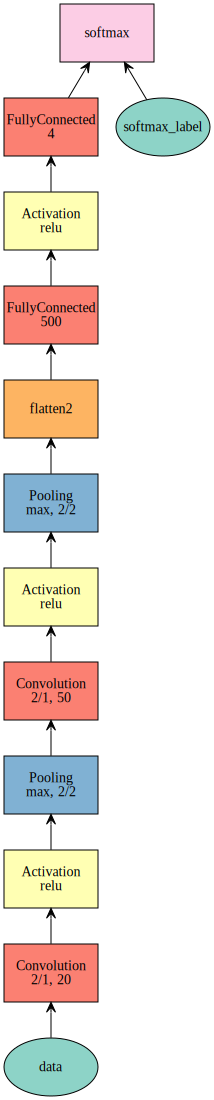

In [6]:
mx.viz.plot_network(lenet)

Let's now train the CNN model. This is similar to the `sklearn` interface. We call the `fit` function to train the model

In [26]:
#training the CNN model
cnn_model.fit(train_data,
                eval_data=val_data,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01,'momentum':0.9},
                eval_metric='acc',
                num_epoch=100)

Now, let's see what the test accuracy is

In [27]:
#Test accuracy of the CNN model
acc = mx.metric.Accuracy()
cnn_model.score(test_data, acc)
probabilities = cnn_model.predict(test_data)
predictions = nd.argmax(probabilities, axis=1)
output = np.vectorize(fizz_buzz)(np.arange(1, 101), predictions.asnumpy().astype(np.int))
print(output)
print("Test Accuracy : ",acc.get_name_value()[0][1])

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44' '45' '46'
 '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61'
 '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76'
 '77' '78' '79' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91'
 '92' '93' '94' '95' '96' '97' '98' '99' '100']
Test Accuracy :  0.53


Clearly, this model has overfitting and all the output are only the actual numbers. The three classes - "fizz", "buzz" and "fizzbuzz" are missing from the output.

**Conclusion and Next Steps**

This article gave a quick overview of how to get started with `mxnet` and `gluon`. With `gluon`, prototyping and experimenting with various architectures is much faster. `autograd` allows us to record computation history on the fly so as to calculate gradients later. 

[The straight dope](https://github.com/zackchase/mxnet-the-straight-dope/) has a good set of tutorials to get started with `mxnet`.

While this article briefly touched upon Convolutional Neural Networks, it didn't provide enough motivation and real-life use cases. While we saw models overfitting, we didn't get into how to overcome overfitting. In the next article, we will show how to build models to do image recognition with some real-life use cases.
